In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

import numpy as np

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset,DataLoader

def patchify(images, n_patches):
    n,c,h,w = images.shape
    patches = torch.zeros(n,n_patches**2, h*w//n_patches**2) #(34000, 100,25)
    patch_size = h//n_patches

    for idx,image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
                patches[idx,i*n_patches+j] = patch.flatten()
    return patches

def get_positional_embeddings(sequence_length,d):
    result = torch.ones(sequence_length,d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i/(10000**(j/d))) if j%2==0 else np.cos(i/(10000**((j-1)/d)))
    return result

class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

class tang_vit(nn.Module):
    def __init__(self,chw = (1,50,50),n_patches =10,n_blocks=4,hidden_d=12, n_heads=2):
        super(tang_vit,self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)

        
        #linear mapping of patches (could also convolve)
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d) #runnig 1:1 map from (3400,100,25) through a (25,12) mapper. so only happens on last dim

        #class token (learnable)
        #self.class_token = nn.Parameter(torch.rand(1,self.hidden_d))

        #pos embed
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches**2,self.hidden_d)))
        self.pos_embed.requires_grad=False

        #transformer blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_d,n_heads) for _ in range(n_blocks)])

        #flatten
        self.flatten = nn.Flatten()

        #linear
        self.linear = nn.Linear((n_patches**2) *hidden_d,1) #nn.Linear(self.hidden_d,1)

    def forward(self, images):
        n,c,h,w = images.shape
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        #We can now add a parameter to our model and convert our (N, 100, 12) tokens tensor to an (N, 101, 12) tensor (we add the special token to each sequence).
        #added at front
        #tokens = torch.stack([torch.vstack((self.class_token,tokens[i])) for i in range(len(tokens))])

        #add pos embed
        pos_embed = self.pos_embed.repeat(n,1,1) #tokens have size (3400, 101, 12)
        out = tokens+pos_embed

        #transformer
        for block in self.blocks:
            out = block(out)
        
        out = self.flatten(out)
        return self.linear(out)

class ImageDataset(Dataset):
    def __init__(self, data, labels, num_neurons):
        self.data = data
        self.labels = labels
        self.num_neurons = num_neurons

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img = torch.tensor(self.data[index], dtype=torch.float)
        label = torch.tensor(self.labels[index, 0:self.num_neurons], dtype=torch.float)
        return img, label

In [3]:
img = np.load('../all_sites_data_prepared/pics_data/train_img_m1s1.npy')
resp = np.load('../all_sites_data_prepared/New_response_data/trainRsp_m1s1.npy')
img=np.reshape(img,(34000,1,50,50))
print(img.shape)
print(resp.shape)

(34000, 1, 50, 50)
(34000, 302)


In [26]:
numneurons = 1
dataset = ImageDataset(img,resp,numneurons)
loader = DataLoader(dataset,8,shuffle=True)
net = tang_vit(n_patches=5,n_blocks=4,hidden_d=12,n_heads=2)#models 1 neuron
opt = torch.optim.Adam(net.parameters(),lr=0.001)
lfunc = torch.nn.MSELoss()
vimg = np.load('../all_sites_data_prepared/pics_data/val_img_m1s1.npy')
vresp = np.load('../all_sites_data_prepared/New_response_data/valRsp_m1s1.npy')
vimg = np.reshape(vimg,(1000,1,50,50))
vdataset = ImageDataset(vimg,vresp,numneurons)
vloader = DataLoader(vdataset,len(vresp),shuffle=False)#

/var/folders/y0/p78gsyrd5wv23ft_8q993_9r0000gn/T/ipykernel_51134/4112635770.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches**2,self.hidden_d)))


In [27]:
n0resp = [t[0] for t in vresp]
print(len(n0resp))

1000


In [28]:
n0respord = []
for i,r in enumerate(n0resp):
    n0respord.append((i,r))


In [29]:
n0respord = sorted(n0respord,key=lambda x:x[1],reverse=True)

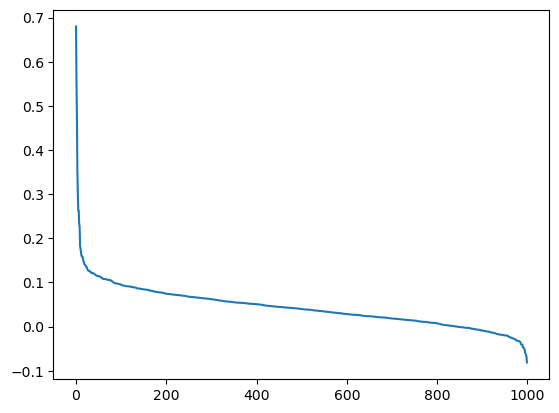

In [30]:
plt.plot([i for i in range(len(n0respord))],[x[1] for x in n0respord])
plt.show()

In [31]:
net.load_state_dict(torch.load("./model-best5.pth"))

<All keys matched successfully>

In [32]:
images = np.asarray([item[0:1] for item in vresp])
responses = torch.from_numpy(np.float32(vimg))
with torch.no_grad():
    net.eval()
    responses2 = net(responses).detach().numpy()
images = np.transpose(images)
responses2 = np.transpose(responses2)
corrs = []
for i in range(1):
    corrs.append(np.corrcoef(images[i], responses2[i])[0][1])
    print(corrs)
print(np.mean(corrs))

[0.3056501515331857]
0.3056501515331857


In [33]:
r = torch.from_numpy(np.float32(vimg))
with torch.no_grad():
        net.eval()
        r = net(r).detach().numpy()

In [34]:
r = [a for a in r]
r = list(r)
r

[array([0.05377882], dtype=float32),
 array([0.07924532], dtype=float32),
 array([0.05790272], dtype=float32),
 array([0.04734625], dtype=float32),
 array([0.04544843], dtype=float32),
 array([0.07729188], dtype=float32),
 array([0.10422549], dtype=float32),
 array([0.06330554], dtype=float32),
 array([0.03984272], dtype=float32),
 array([0.04933008], dtype=float32),
 array([0.02068291], dtype=float32),
 array([0.07459679], dtype=float32),
 array([0.01996984], dtype=float32),
 array([0.00896041], dtype=float32),
 array([0.04215038], dtype=float32),
 array([0.03887857], dtype=float32),
 array([0.02336688], dtype=float32),
 array([0.02857628], dtype=float32),
 array([0.04312263], dtype=float32),
 array([0.04089689], dtype=float32),
 array([0.21439621], dtype=float32),
 array([0.09062736], dtype=float32),
 array([0.11241291], dtype=float32),
 array([0.04402805], dtype=float32),
 array([0.02031677], dtype=float32),
 array([0.07352034], dtype=float32),
 array([0.03342861], dtype=float32),
 

In [35]:
temp = []
with torch.no_grad():
    net.eval()
    for x,y in vloader:
        print(x.shape)
        temp.append(net(x))
#does the same as above

torch.Size([1000, 1, 50, 50])


In [36]:
n0netord = []
ord= [x[0] for x in n0respord]
for i in ord:
    n0netord.append(r[i])
n0netord

[array([0.08603222], dtype=float32),
 array([0.07048836], dtype=float32),
 array([0.01952424], dtype=float32),
 array([0.08056728], dtype=float32),
 array([0.0735499], dtype=float32),
 array([0.04785974], dtype=float32),
 array([0.11241291], dtype=float32),
 array([0.0799712], dtype=float32),
 array([0.12879016], dtype=float32),
 array([0.10799304], dtype=float32),
 array([0.07851154], dtype=float32),
 array([0.06612858], dtype=float32),
 array([0.04774107], dtype=float32),
 array([0.20632222], dtype=float32),
 array([0.07280057], dtype=float32),
 array([0.06063751], dtype=float32),
 array([0.11629846], dtype=float32),
 array([0.11883361], dtype=float32),
 array([0.11847816], dtype=float32),
 array([0.05578043], dtype=float32),
 array([0.08268246], dtype=float32),
 array([0.08209668], dtype=float32),
 array([0.02173537], dtype=float32),
 array([0.07924532], dtype=float32),
 array([0.02909792], dtype=float32),
 array([0.03739332], dtype=float32),
 array([0.03963929], dtype=float32),
 ar

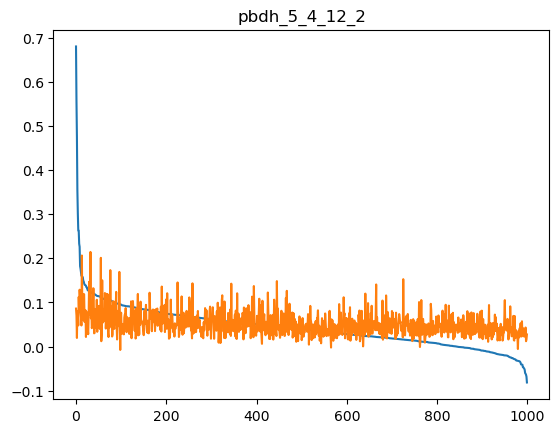

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot([i for i in range(len(n0respord))],[x[1] for x in n0respord])
ax1.plot([i for i in range(len(n0netord))],[x for x in n0netord])
plt.title("pbdh_5_4_12_2")
plt.show()